Trovati 17 test: ['A1_random', 'A2_balanced_degree', 'A3_corridor_heavy', 'A4_goal_biased', 'A5_wall_band', 'A6_uniform_grid', 'B1_deg_strong', 'B2_goal_strong', 'B3_wide_space', 'B4_path_strong', 'B5_gate_strong', 'C1_easy_pairs', 'C2_hard_pairs', 'C3_very_hard_diverse_deg', 'D1_small_net', 'D2_dropout_heavy', 'D3_more_epochs']
Creating Path with step 3


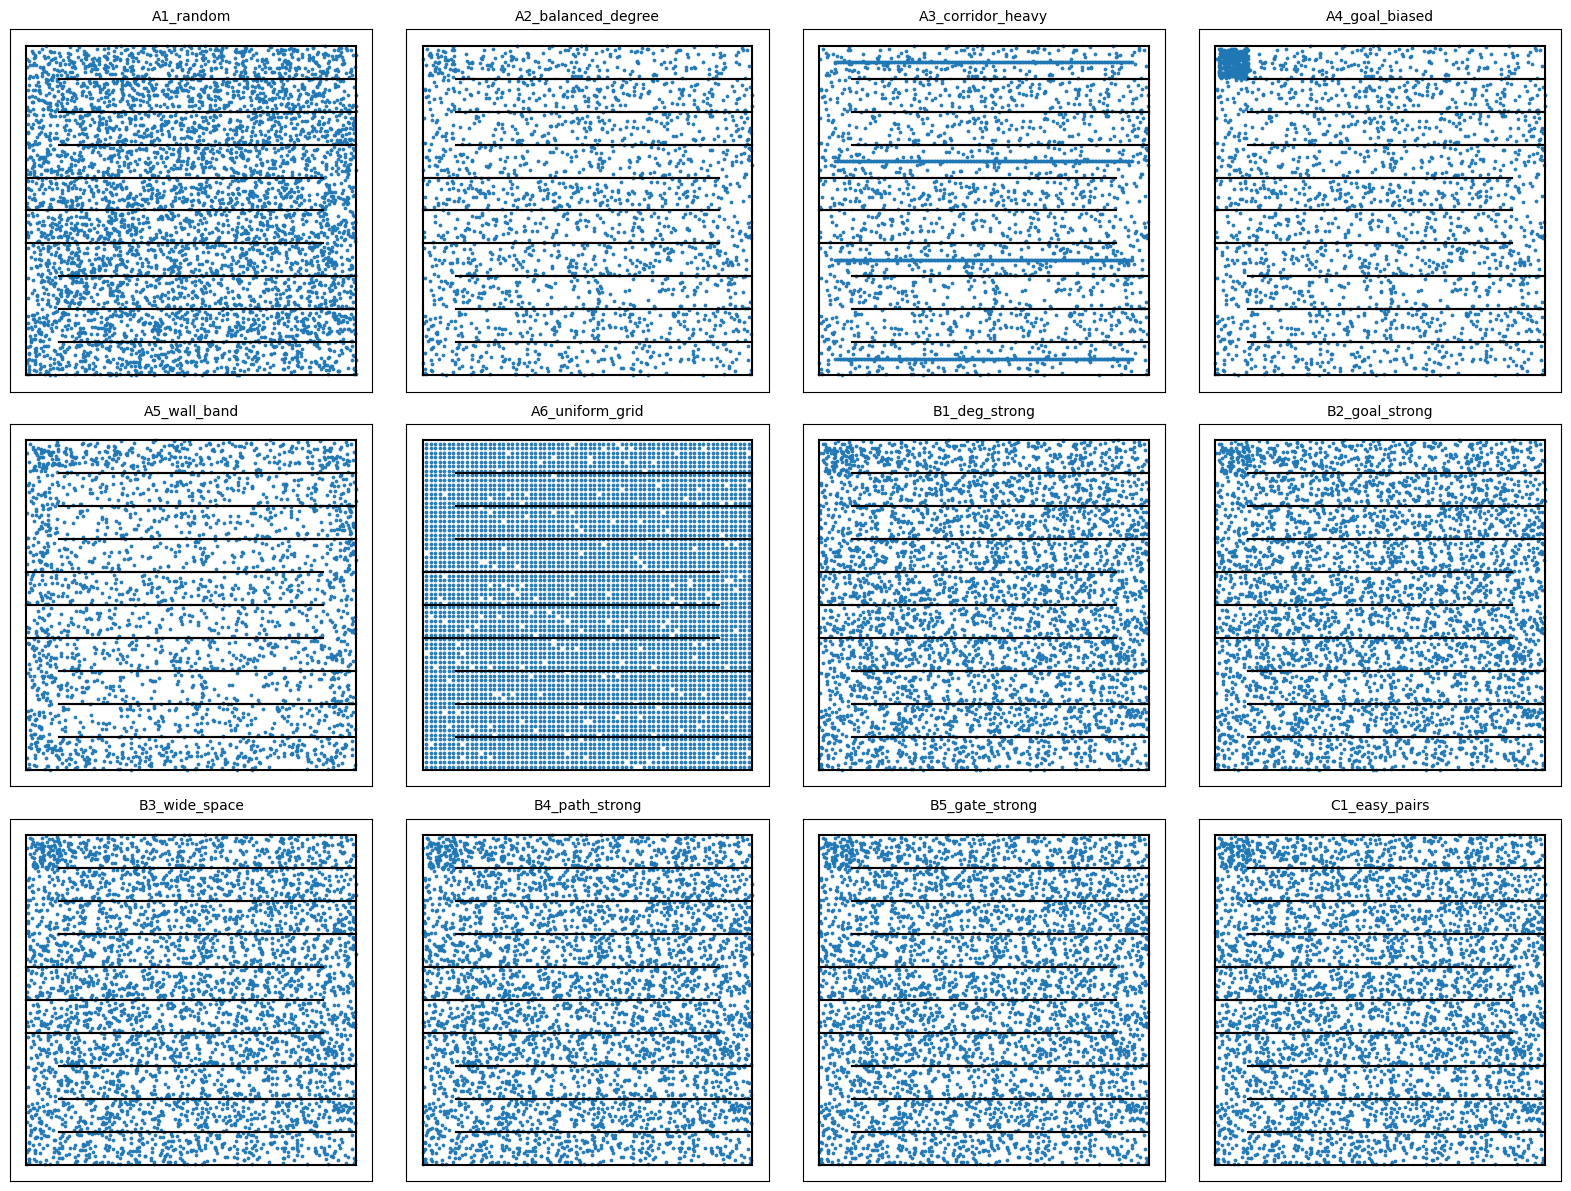

Salvato: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_overview/points_grid_1.png


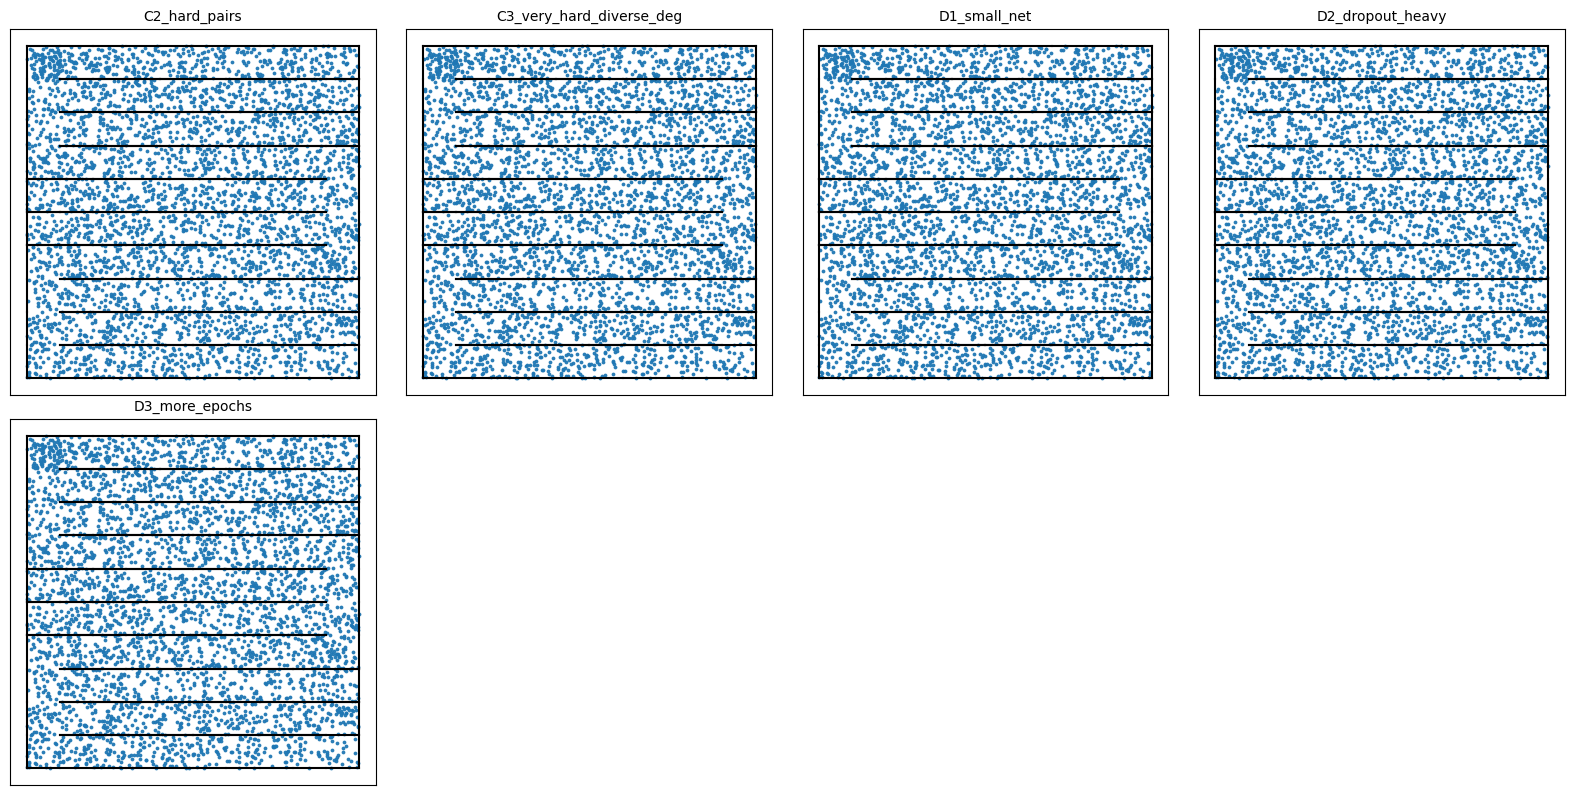

Salvato: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_overview/points_grid_2.png


In [1]:
# --- Maze + Points overview per tutti i test ---
# incolla in una cella di visualization.ipynb
import os, sys, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imposta i path in base alla posizione del notebook:
# se il notebook è in preferencelearning-main/comparison/, "outputs" è locale.
BASE = Path.cwd()
if BASE.name == "comparison":
    OUTPUTS_DIR = BASE / "outputs"
    SRC_DIR = BASE.parent / "src"
else:
    # fallback: notebook lanciato da root del repo
    OUTPUTS_DIR = BASE / "comparison" / "outputs"
    SRC_DIR = BASE / "src"

assert OUTPUTS_DIR.exists(), f"Cartella output non trovata: {OUTPUTS_DIR}"
assert SRC_DIR.exists(), f"Cartella src non trovata: {SRC_DIR}"

# Importa funzioni dal progetto
sys.path.insert(0, str(SRC_DIR))
from maze import Maze
from maze_env import draw_map  # disegna il labirinto

# --- Parametri di visualizzazione (personalizzabili) ---
N_COLS = 4                    # colonne nella griglia
CHUNK = 12                    # quanti test per figura (pagine da 12 subplots)
MAX_POINTS_PER_TEST = 5000    # sottocampiona per non saturare i plot
COLOR_BY = None               # None oppure nome colonna, es: "total_score" / "degree" / "distance_to_goal"
SCATTER_SIZE = 3
ALPHA = 0.9
SEED = 0

# Rileva tutti i test che hanno positions.parquet
test_dirs = sorted([p for p in OUTPUTS_DIR.iterdir() if (p / "positions.parquet").exists()])
test_names = [p.name for p in test_dirs]
print(f"Trovati {len(test_names)} test:", test_names)

# Crea il Maze "serpentina" (stesso di training/generazione)
maze = Maze(10, 10, 0, 0)
maze.make_maze_fail(step=3)  # serpentina con step=3

rng = np.random.default_rng(SEED)

def plot_chunk(test_paths):
    n = len(test_paths)
    n_cols = N_COLS
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    for ax, tdir in zip(axes.ravel(), test_paths):
        # Disegna il maze
        draw_map(1/10, maze, ax=ax, alpha=1.0)

        # Carica punti
        df = pd.read_parquet(tdir / "positions.parquet")
        if MAX_POINTS_PER_TEST is not None and len(df) > MAX_POINTS_PER_TEST:
            df = df.sample(MAX_POINTS_PER_TEST, random_state=SEED)

        # Scatter: solo punti o colorati per una metrica
        if COLOR_BY and COLOR_BY in df.columns:
            sc = ax.scatter(df["x"].values, df["y"].values, s=SCATTER_SIZE,
                            c=df[COLOR_BY].values, cmap="viridis", alpha=ALPHA)
            # Colorbar piccola per ogni subplot
            cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
            cb.ax.tick_params(labelsize=8)
        else:
            ax.scatter(df["x"].values, df["y"].values, s=SCATTER_SIZE, alpha=ALPHA)

        ax.set_title(tdir.name, fontsize=10)
        ax.set_aspect("equal")
        ax.invert_xaxis()
        ax.set_xticks([]); ax.set_yticks([])

    # Nasconde eventuali assi in eccesso
    for ax in axes.ravel()[n:]:
        ax.axis("off")

    plt.tight_layout()
    return fig

# Genera figure in "pagine"
overview_dir = OUTPUTS_DIR / "_overview"
overview_dir.mkdir(exist_ok=True)

for i in range(0, len(test_dirs), CHUNK):
    batch = test_dirs[i:i+CHUNK]
    fig = plot_chunk(batch)
    out_path = overview_dir / f"points_grid_{i//CHUNK + 1}.png"
    fig.savefig(out_path, dpi=150)
    plt.show()
    print(f"Salvato: {out_path}")


In [2]:
# Diagnostica: quante azioni sono "legali" allo stato iniziale?
import json, numpy as np
from pathlib import Path
import sys, os

# path di progetto
BASE = Path.cwd()
if (BASE / "src").is_dir():
    SRC = BASE / "src"
elif (BASE.parent / "src").is_dir():
    SRC = BASE.parent / "src"
else:
    raise RuntimeError("Non trovo 'src/'")

sys.path.insert(0, str(SRC))
from maze import Maze
from maze_env import MazeEnv

def candidate_actions(env):
    angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
    fine = [0.002, 0.005, 0.008]
    speeds = fine + [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
    cell = 1.0 / env.sz
    speeds = [0.5*cell/env.dt, 0.8*cell/env.dt, cell/env.dt] + speeds
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)

def is_legal(env, s_from, s_to, n=4):
    # stesso controllo dei punti intermedi (poco costoso)
    alphas = np.linspace(0., 1., n)
    for a in alphas:
        p = (1-a)*s_from + a*s_to
        if env.point_collision(p[0], p[1]):
            return False
    # attenzione: il check segmento-segmento può risultare troppo severo
    return not env.segment_collision(s_from, s_to)

def count_legal_actions(dt=0.15, horizon=180):
    maze = Maze(10,10,0,0)
    env  = MazeEnv(sz=10, maze=maze, start=np.array([0.05,0.05]),
                   goal=np.array([0.95,0.95]), reward="distance",
                   dt=dt, horizon=horizon, slide=1, use_dpo=False)
    acts = candidate_actions(env)
    legal = 0
    for a in acts:
        nxt = env.state + a[0]*env.dt*np.array([np.cos(a[1]*np.pi), np.sin(a[1]*np.pi)])
        # legal?
        if is_legal(env, env.state, nxt):
            legal += 1
    return legal, len(acts)

legal, total = count_legal_actions()
print(f"Azioni legali allo start: {legal}/{total}")


Creating Path with step 3
Azioni legali allo start: 323/416


In [3]:
# Diagnostica mismatch: policy_legal vs step_collision
import sys, os, numpy as np
from pathlib import Path

BASE = Path.cwd()
SRC = BASE / "src" if (BASE / "src").is_dir() else BASE.parent / "src"
sys.path.insert(0, str(SRC))

from maze import Maze
from maze_env import MazeEnv

def candidate_actions(env):
    angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
    fine = [0.002, 0.005, 0.008]
    speeds = fine + [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
    cell = 1.0 / env.sz
    speeds = [0.5*cell/env.dt, 0.8*cell/env.dt, cell/env.dt] + speeds
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)

def is_legal_policy(env, s_from, s_to, n=4):
    # quello che usavamo nel rollout: campionamento + segment_collision (strict=True)
    alphas = np.linspace(0., 1., n)
    for a in alphas:
        p = (1-a)*s_from + a*s_to
        if env.point_collision(p[0], p[1]):
            return False
    return not env.segment_collision(s_from, s_to)  # strict=True dentro la definizione

def step_would_collide(env, s_to):
    # esattamente ciò che fa step() per la collisione del segmento start->s_to
    return env.collision(s_to)

# -- setup env baseline
maze = Maze(10,10,0,0)
env  = MazeEnv(sz=10, maze=maze, start=np.array([0.05,0.05]),
               goal=np.array([0.95,0.95]), reward="distance",
               dt=0.15, horizon=180, slide=1, use_dpo=False)

acts = candidate_actions(env)

for t in range(20):  # pochi step di diagnostica
    next_states = env.state + np.stack(
        [acts[:,0]*np.cos(acts[:,1]*np.pi)*env.dt,
         acts[:,0]*np.sin(acts[:,1]*np.pi)*env.dt], axis=1)

    pol_legal = []
    step_ok   = []
    mismatch  = []
    for i, s1 in enumerate(next_states):
        Lp = is_legal_policy(env, env.state, s1)
        Ls = not step_would_collide(env, s1)
        pol_legal.append(Lp)
        step_ok.append(Ls)
        mismatch.append(Lp and (not Ls))

    print(f"step {t:02d} | policy_legal={np.sum(pol_legal)} | step_ok={np.sum(step_ok)} | mismatch={np.sum(mismatch)} | dist={np.linalg.norm(env.goal-env.state):.3f}")

    # muovi con una mossa sicura secondo LO STESSO criterio dello step (per avanzare)
    idxs_ok = np.where(np.array(step_ok))[0]
    if len(idxs_ok)==0:
        # resta fermo (diagnostica)
        pass
    else:
        # prendi fra quelle ok quella che più riduce la distanza
        dists = np.linalg.norm(env.goal - next_states[idxs_ok], axis=1)
        a = acts[idxs_ok[np.argmin(dists)]]
        new_pose = env.state + a[0]*env.dt*np.array([np.cos(a[1]*np.pi), np.sin(a[1]*np.pi)])
        env.step(a, epsilon_goal=0.106)
    if np.linalg.norm(env.goal - env.state) < 0.106:
        print("✅ goal raggiunto durante la diagnostica")
        break


Creating Path with step 3
step 00 | policy_legal=323 | step_ok=319 | mismatch=4 | dist=1.273
Step called. Counter: 0, Horizon: 180
step 01 | policy_legal=292 | step_ok=292 | mismatch=0 | dist=1.163
Step called. Counter: 1, Horizon: 180
step 02 | policy_legal=292 | step_ok=292 | mismatch=0 | dist=1.085
Step called. Counter: 2, Horizon: 180
step 03 | policy_legal=292 | step_ok=292 | mismatch=0 | dist=1.015
Step called. Counter: 3, Horizon: 180
step 04 | policy_legal=292 | step_ok=292 | mismatch=0 | dist=0.956
Step called. Counter: 4, Horizon: 180
step 05 | policy_legal=292 | step_ok=292 | mismatch=0 | dist=0.908
Step called. Counter: 5, Horizon: 180
step 06 | policy_legal=292 | step_ok=292 | mismatch=0 | dist=0.875
Step called. Counter: 6, Horizon: 180
step 07 | policy_legal=297 | step_ok=297 | mismatch=0 | dist=0.857
Step called. Counter: 7, Horizon: 180
step 08 | policy_legal=279 | step_ok=281 | mismatch=0 | dist=0.832
Step called. Counter: 8, Horizon: 180
step 09 | policy_legal=280 | 

In [4]:
# Diagnostica: quante azioni legali riducono (a) distanza euclidea e (b) distanza di percorso (BFS)?
import sys, os, numpy as np
from pathlib import Path
from collections import deque

BASE = Path.cwd()
SRC = BASE / "src" if (BASE / "src").is_dir() else BASE.parent / "src"
sys.path.insert(0, str(SRC))

from maze import Maze
from maze_env import MazeEnv

def candidate_actions(env):
    angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
    fine = [0.002, 0.005, 0.008]
    speeds = fine + [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
    cell = 1.0 / env.sz
    speeds = [0.5*cell/env.dt, 0.8*cell/env.dt, cell/env.dt] + speeds
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)

def can_move(env, cx, cy, nx, ny):
    if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
        return False
    if all(env.maze.cell_at(nx, ny).walls.values()):
        return False
    c  = env.maze.cell_at(cx, cy)
    n  = env.maze.cell_at(nx, ny)
    dx, dy = nx - cx, ny - cy
    if   dx==0 and dy==-1 and (c.walls["N"] or n.walls["S"]): return False
    elif dx==0 and dy== 1 and (c.walls["S"] or n.walls["N"]): return False
    elif dx== 1 and dy==0  and (c.walls["E"] or n.walls["W"]): return False
    elif dx==-1 and dy==0  and (c.walls["W"] or n.walls["E"]): return False
    return True

def shortest_path_cells(env, s):
    cx, cy = min(int(s[0]*env.sz), env.maze.nx-1), min(int(s[1]*env.sz), env.maze.ny-1)
    gx, gy = min(int(env.goal[0]*env.sz), env.maze.nx-1), min(int(env.goal[1]*env.sz), env.maze.ny-1)
    dist = { (cx,cy): 0 }
    Q = deque([(cx,cy)])
    while Q:
        ux, uy = Q.popleft()
        if (ux,uy) == (gx,gy): break
        for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            vx, vy = ux+dx, uy+dy
            if not can_move(env, ux, uy, vx, vy): continue
            if (vx,vy) not in dist:
                dist[(vx,vy)] = dist[(ux,uy)] + 1
                Q.append((vx,vy))
    return dist.get((gx,gy), np.inf)

# Setup
maze = Maze(10,10,0,0)
env  = MazeEnv(sz=10, maze=maze, start=np.array([0.05,0.05]),
               goal=np.array([0.95,0.95]), reward="distance",
               dt=0.15, horizon=180, slide=1, use_dpo=False)
acts = candidate_actions(env)

for t in range(20):
    next_states = env.state + np.stack(
        [acts[:,0]*np.cos(acts[:,1]*np.pi)*env.dt,
         acts[:,0]*np.sin(acts[:,1]*np.pi)*env.dt], axis=1)

    # legali secondo lo step (segmento non collide)
    idxs_ok = [i for i in range(len(acts)) if not env.collision(next_states[i])]

    d0 = float(np.linalg.norm(env.goal - env.state))
    p0 = shortest_path_cells(env, env.state)

    dists = np.linalg.norm(env.goal - next_states[idxs_ok], axis=1)
    paths = np.array([shortest_path_cells(env, s) for s in next_states[idxs_ok]])

    eu_improve   = np.sum(dists < d0 - 1e-6)
    path_improve = np.sum(paths < p0 - 1e-9)

    print(f"step {t:02d} | legal={len(idxs_ok)} | eu_improve={eu_improve} | path_improve={path_improve} | dist={d0:.3f} | path={p0}")

    # muovi con criterio dello step per proseguire
    if len(idxs_ok)==0:
        break
    # prova prima euclidea; se none, scegli min path
    if eu_improve > 0:
        i = idxs_ok[np.argmin(dists)]
    else:
        i = idxs_ok[np.argmin(paths)]
    a = acts[i]
    env.step(a, epsilon_goal=0.106)
    if np.linalg.norm(env.goal - env.state) < 0.106:
        print("✅ goal raggiunto (diagnostica)")
        break


Creating Path with step 3
step 00 | legal=319 | eu_improve=161 | path_improve=23 | dist=1.273 | path=36
Step called. Counter: 0, Horizon: 180
step 01 | legal=292 | eu_improve=115 | path_improve=26 | dist=1.163 | path=35
Step called. Counter: 1, Horizon: 180
step 02 | legal=292 | eu_improve=115 | path_improve=37 | dist=1.085 | path=34
Step called. Counter: 2, Horizon: 180
step 03 | legal=292 | eu_improve=107 | path_improve=5 | dist=1.015 | path=32
Step called. Counter: 3, Horizon: 180
step 04 | legal=292 | eu_improve=107 | path_improve=10 | dist=0.956 | path=31
Step called. Counter: 4, Horizon: 180
step 05 | legal=292 | eu_improve=100 | path_improve=15 | dist=0.908 | path=30
Step called. Counter: 5, Horizon: 180
step 06 | legal=292 | eu_improve=95 | path_improve=26 | dist=0.875 | path=29
Step called. Counter: 6, Horizon: 180
step 07 | legal=297 | eu_improve=99 | path_improve=42 | dist=0.857 | path=28
Step called. Counter: 7, Horizon: 180
step 08 | legal=281 | eu_improve=144 | path_impro

DPO wins: 0 | ties: 0 | losses: 0 | avg Δsteps (baseline−DPO): nan


,test_id,n_points,n_pairs,best_val,test_accuracy,dpo_steps,baseline_steps,delta_steps
0,A1_random,6000,200000,0.031451,0.947700,NaN,29,NaN
1,A2_balanced_degree,2070,95151,0.037719,0.942821,NaN,29,NaN
2,A3_corridor_heavy,2810,110083,0.026572,0.959847,NaN,29,NaN
3,A4_goal_biased,2439,105209,0.034401,0.950010,NaN,29,NaN
4,A5_wall_band,2560,115128,0.031807,0.945979,NaN,29,NaN
5,A6_uniform_grid,5184,200000,0.025415,0.962300,NaN,29,NaN
6,B1_deg_strong,4130,80000,0.016841,0.974500,NaN,29,NaN
7,B2_goal_strong,4130,200000,0.026442,0.964900,NaN,29,NaN
8,B3_wide_space,4130,200000,0.100196,0.836900,NaN,29,NaN
9,B4_path_strong,4130,200000,0.037891,0.945800,NaN,29,NaN


✓ Salvato CSV: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_metrics_summary.csv


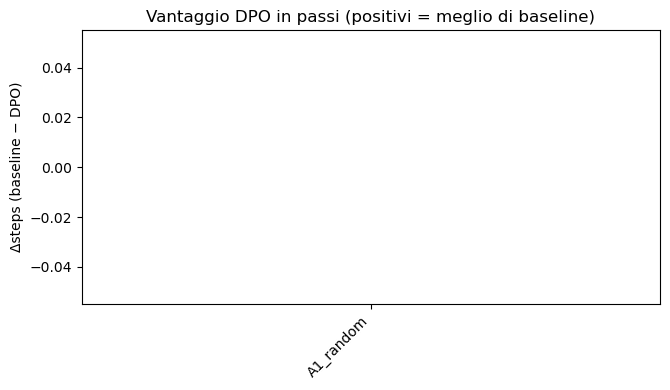

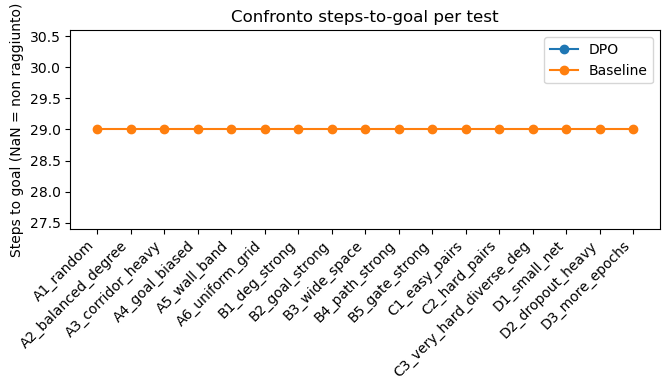

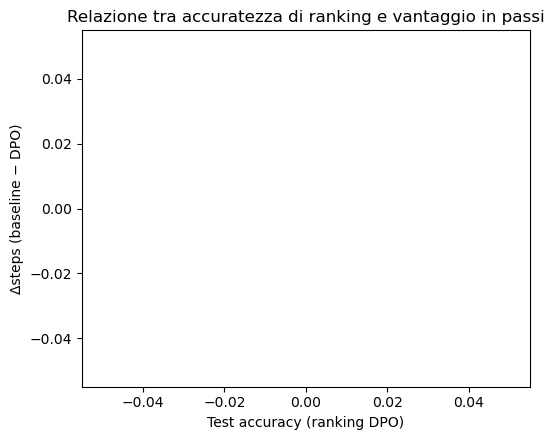

In [5]:
# ## Confronto numerico dai report.json
# - Aggrega metriche
# - Calcola delta_steps = baseline - dpo
# - Mostra tabella e tre grafici separati
import os, sys, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings("ignore", category=UserWarning)

def find_outputs_dir():
    candidates = [
        Path.cwd() / "outputs",
        Path.cwd() / "comparison" / "outputs",
        Path.cwd().parent / "comparison" / "outputs",
        Path.cwd().parent.parent / "comparison" / "outputs",
    ]
    for p in candidates:
        if p.is_dir():
            return p.resolve()
    raise FileNotFoundError("Non trovo 'comparison/outputs'. Apri il notebook dentro 'comparison/' o aggiorna i path.")

OUTPUTS_DIR = find_outputs_dir()

# --- carica report.json di tutti i test ---
records = []
for tdir in sorted(OUTPUTS_DIR.iterdir()):
    if not tdir.is_dir(): 
        continue
    rpath = tdir / "report.json"
    if not rpath.exists():
        continue
    with open(rpath, "r") as f:
        rep = json.load(f)

    # safe cast: -1 -> NaN (non raggiunto)
    def ok_steps(x):
        try:
            v = int(x)
            return np.nan if v < 0 else v
        except Exception:
            return np.nan

    rec = {
        "test_id": rep.get("test_id", tdir.name),
        "n_points": rep.get("n_points", np.nan),
        "n_pairs": rep.get("n_pairs", np.nan),
        "best_val": rep.get("training", {}).get("best_val", np.nan),
        "test_accuracy": rep.get("training", {}).get("test_accuracy", np.nan),
        "dpo_steps": ok_steps(rep.get("solve", {}).get("dpo_steps_to_goal", np.nan)),
        "baseline_steps": ok_steps(rep.get("solve", {}).get("baseline_steps_to_goal", np.nan)),
    }
    # delta positivo = DPO meglio (meno passi)
    if np.isnan(rec["dpo_steps"]) or np.isnan(rec["baseline_steps"]):
        rec["delta_steps"] = np.nan
    else:
        rec["delta_steps"] = rec["baseline_steps"] - rec["dpo_steps"]

    records.append(rec)

df = pd.DataFrame(records).sort_values("test_id").reset_index(drop=True)

# --- sintesi globale ---
wins = int((df["delta_steps"] > 0).sum())
ties = int((df["delta_steps"] == 0).sum())
loss = int((df["delta_steps"] < 0).sum())
avg_impr = float(df["delta_steps"].dropna().mean()) if df["delta_steps"].notna().any() else np.nan
print(f"DPO wins: {wins} | ties: {ties} | losses: {loss} | avg Δsteps (baseline−DPO): {avg_impr:.2f}")

# --- tabella interattiva + CSV
try:
    import ace_tools
    ace_tools.display_dataframe_to_user("Confronto numerico per test", df)
except Exception:
    display(df)

summary_csv = OUTPUTS_DIR / "_metrics_summary.csv"
df.to_csv(summary_csv, index=False)
print(f"✓ Salvato CSV: {summary_csv}")

# --- GRAFICO 1: Δsteps (baseline - DPO) per test
plt.figure(figsize=(max(6, 0.4*len(df)), 4))
plt.bar(df["test_id"], df["delta_steps"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δsteps (baseline − DPO)")
plt.title("Vantaggio DPO in passi (positivi = meglio di baseline)")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_delta_steps.png", dpi=150)
plt.show()

# --- GRAFICO 2: Steps to goal per test (DPO vs Baseline)
plt.figure(figsize=(max(6, 0.4*len(df)), 4))
plt.plot(df["test_id"], df["dpo_steps"], marker="o", label="DPO")
plt.plot(df["test_id"], df["baseline_steps"], marker="o", label="Baseline")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Steps to goal (NaN = non raggiunto)")
plt.title("Confronto steps-to-goal per test")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_steps_comparison.png", dpi=150)
plt.show()

# --- GRAFICO 3: test_accuracy vs Δsteps
plt.figure(figsize=(5.5, 4.5))
plt.scatter(df["test_accuracy"], df["delta_steps"])
for i, row in df.iterrows():
    plt.annotate(row["test_id"], (row["test_accuracy"], row["delta_steps"]), fontsize=8, xytext=(4,4), textcoords="offset points")
plt.xlabel("Test accuracy (ranking DPO)")
plt.ylabel("Δsteps (baseline − DPO)")
plt.title("Relazione tra accuratezza di ranking e vantaggio in passi")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_acc_vs_delta.png", dpi=150)
plt.show()
